# Data Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns

from process import read_data

In [2]:
plt.rcParams['font.family'] = 'Arial'

## Read Data

In [4]:
years = list(range(2011, 2025))
folder_path = '../data/earning/'
file_name = 'earnings.csv'
encoding = 'ISO-8859-1'
target_col = ['REGULAR','RETRO','OTHER','OVERTIME','INJURED','DETAIL','QUINN_EDUCATION','TOTAL_GROSS']
drop_col = ['_ID', 'POSTAL']
# Read all the data
dfs = read_data(folder_path, file_name, years, encoding, target_col, drop_col)

Read data from: ../data/earning/2011_earnings.csv
Read data from: ../data/earning/2012_earnings.csv
Read data from: ../data/earning/2013_earnings.csv
Read data from: ../data/earning/2014_earnings.csv
Read data from: ../data/earning/2015_earnings.csv
Read data from: ../data/earning/2016_earnings.csv
Read data from: ../data/earning/2017_earnings.csv
Read data from: ../data/earning/2018_earnings.csv
Read data from: ../data/earning/2019_earnings.csv
Read data from: ../data/earning/2020_earnings.csv
Read data from: ../data/earning/2021_earnings.csv
Read data from: ../data/earning/2022_earnings.csv
Read data from: ../data/earning/2023_earnings.csv
Read data from: ../data/earning/2024_earnings.csv
Successfully read data from all files.


## Data Preprocessing

In [6]:
# Concatenate all year dataframes into a single dataframe
full_data = pd.concat(dfs, ignore_index=True)

# Check for missing values
missing_values = full_data.isnull().sum()
print("Missing values in each column:")
print(missing_values)
full_data['DEPARTMENT_NAME'] = full_data['DEPARTMENT_NAME'].fillna('')

# Remove rows missing TOTAL_GROSS
full_data = full_data.dropna(subset=['TOTAL_GROSS'])

# display random 10 rows from 2023
print("\nSample from 2023:")
display(full_data[full_data['YEAR'] == 2023].sample(10))

# Seperate BPD and non-BPD data
bpd_data = full_data[full_data['DEPARTMENT_NAME'].str.upper().str.contains('POLICE')]
non_bpd_data = full_data[~full_data['DEPARTMENT_NAME'].str.upper().str.contains('POLICE')]

Missing values in each column:
NAME                    6
DEPARTMENT_NAME         6
TITLE                   6
REGULAR             13327
RETRO              243646
OTHER              125559
OVERTIME           222356
INJURED            298158
DETAIL             285465
QUINN_EDUCATION    299682
TOTAL_GROSS             8
YEAR                    0
dtype: int64

Sample from 2023:


,NAME,DEPARTMENT_NAME,TITLE,REGULAR,RETRO,OTHER,OVERTIME,INJURED,DETAIL,QUINN_EDUCATION,TOTAL_GROSS,YEAR
280855,"Lynch,Christopher Gerard",Assessing Department,Asst Assessor,70384.64,NaN,1592.20,NaN,NaN,NaN,NaN,71976.84,2023
268766,"Cardoso,Adilson",Boston Latin Academy,School Counselor,153844.72,5939.61,12246.36,NaN,NaN,NaN,NaN,172030.69,2023
274133,"Welch,Erica D",Boston Teachers Union K-8,Teacher,120803.35,4963.62,NaN,NaN,NaN,NaN,NaN,125766.97,2023
272033,"Nouveaux,Genevieve",Greater Egleston High,Teacher,130285.31,5433.88,1170.88,NaN,NaN,NaN,NaN,136890.07,2023
281021,"Pujols,Felix",Food & Nutrition Services,Sr. Shipping&Receiving Worker,61402.51,5305.45,3050.00,633.57,NaN,NaN,NaN,70391.53,2023
271277,"Lee,Steven",Quincy Elementary,Teacher,134802.11,5275.45,948.42,NaN,NaN,NaN,NaN,141025.98,2023
275824,"White,Marsha",Boston Latin Academy,Manager (D) (non-ac),95455.10,1682.90,17331.06,NaN,NaN,NaN,NaN,114469.06,2023
279724,"Amaral,Deborah J",Traffic Division,Parking Meter Supervisor,66604.69,NaN,250.00,15035.93,NaN,NaN,NaN,81890.62,2023
286005,"Johnson-Daye,Rayla",Channing Elementary,Paraprofessional,28473.87,2371.94,750.00,NaN,NaN,NaN,NaN,31595.81,2023
270565,"Rodriguez,Celines",Tynan Elementary,Teacher,128361.59,4066.56,13713.50,NaN,NaN,NaN,NaN,146141.65,2023


# How have BPD paychecks changed year-over-year?

In [9]:
# Calcaulate average gross
bpd_avg = bpd_data.groupby('YEAR')['TOTAL_GROSS'].mean().reset_index(name='BPD_AVG_GROSS')
non_bpd_avg = non_bpd_data.groupby('YEAR')['TOTAL_GROSS'].mean().reset_index(name='NON_BPD_AVG_GROSS')

avg_comparison = pd.merge(bpd_avg, non_bpd_avg, on='YEAR', how='outer').sort_values('YEAR')

avg_comparison

,YEAR,BPD_AVG_GROSS,NON_BPD_AVG_GROSS
0,2011,96421.474132,57553.082168
1,2012,97515.361269,56290.826094
2,2013,99771.862159,55538.289264
3,2014,112589.650642,59304.269696
4,2015,118041.488626,63268.735794
5,2016,124787.164775,62942.269980
6,2017,124254.563280,62820.904814
7,2018,131321.462320,63828.300246
8,2019,127094.346316,68909.359765
9,2020,132487.610436,74998.581716


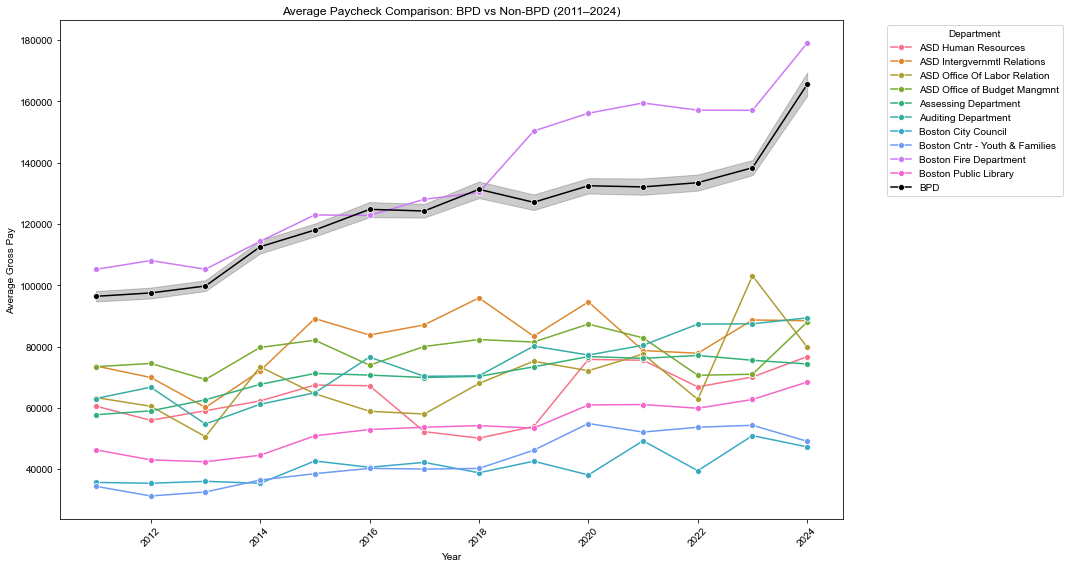

In [10]:
# plot average paycheck for different non-BPD departments
non_bpd_avg = non_bpd_data.groupby(['YEAR', 'DEPARTMENT_NAME'])['TOTAL_GROSS'].mean().reset_index()
non_bpd_avg = non_bpd_avg[non_bpd_avg['DEPARTMENT_NAME'] != '']

# Filter out departments not existing in all years
years = non_bpd_avg['YEAR'].unique()
filtered_departments = [dept for dept in non_bpd_avg['DEPARTMENT_NAME'].unique() if len(non_bpd_avg[non_bpd_avg['DEPARTMENT_NAME'] == dept]['YEAR'].unique()) == len(years)]

# Filter out departments with top 10 most employees in filtered_departments
top_departments = non_bpd_avg[non_bpd_avg['DEPARTMENT_NAME'].isin(filtered_departments)].groupby('DEPARTMENT_NAME')['TOTAL_GROSS'].count().nlargest(10).index.tolist()
filtered_departments = [dept for dept in filtered_departments if dept in top_departments]

# Filter the data to include only the selected departments
filtered_non_bpd_data = non_bpd_avg[non_bpd_avg['DEPARTMENT_NAME'].isin(filtered_departments)]

# Plot the average gross pay for each department by year
plt.figure(figsize=(15, 8))
sns.set_palette("husl", len(filtered_departments))

sns.lineplot(data=filtered_non_bpd_data, x='YEAR', y='TOTAL_GROSS', hue='DEPARTMENT_NAME', marker='o')
sns.lineplot(data=bpd_data, x='YEAR', y='TOTAL_GROSS', label='BPD', color='black', marker='o')
plt.title('Average Paycheck Comparison: BPD vs Non-BPD (2011–2024)')
plt.xlabel('Year')
plt.ylabel('Average Gross Pay')
plt.xticks(rotation=45)
plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()




# How much BPD officer pay came from injury pay?

In [11]:
# Drop rows with missing INJURED values
bpd_data_dropna = bpd_data.dropna(subset=['INJURED'])

# Calculate the ratio of injured pay to total gross
bpd_data_dropna['INJURED_RATIO'] = bpd_data_dropna['INJURED'] / bpd_data_dropna['TOTAL_GROSS']


/var/folders/64/dkndw9l10ls5pdzpx8fmcqpc0000gn/T/ipykernel_71237/3637093187.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bpd_data_dropna['INJURED_RATIO'] = bpd_data_dropna['INJURED'] / bpd_data_dropna['TOTAL_GROSS']


/var/folders/64/dkndw9l10ls5pdzpx8fmcqpc0000gn/T/ipykernel_71237/1374641421.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='YEAR', y='INJURED_RATIO', data=bpd_data_dropna, palette='Set3')


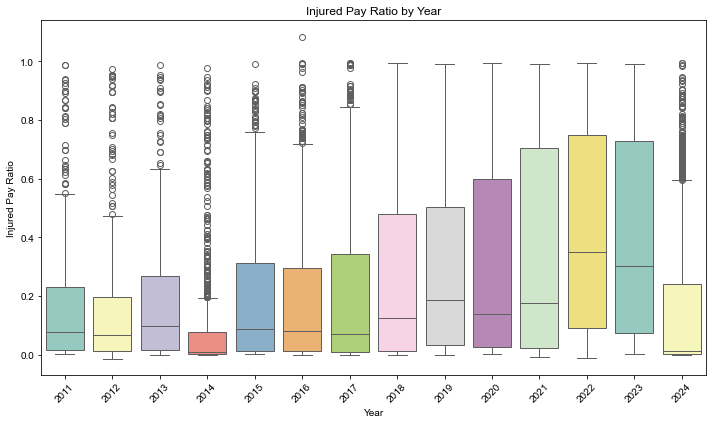

In [12]:
# Plot boxplot of injured pay ratio per year
plt.figure(figsize=(10, 6))
sns.boxplot(x='YEAR', y='INJURED_RATIO', data=bpd_data_dropna, palette='Set3')
plt.title('Injured Pay Ratio by Year')
plt.xlabel('Year')
plt.ylabel('Injured Pay Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
# Calculate the average injured ratio per year
injured_ratio_avg = bpd_data_dropna['INJURED_RATIO'].groupby(bpd_data_dropna['YEAR']).mean().reset_index(name='INJURED_RATIO')

injured_ratio_avg

,YEAR,INJURED_RATIO
0,2011,0.174445
1,2012,0.171357
2,2013,0.185597
3,2014,0.093860
4,2015,0.217756
5,2016,0.212965
6,2017,0.229184
7,2018,0.264143
8,2019,0.292817
9,2020,0.299839


/var/folders/64/dkndw9l10ls5pdzpx8fmcqpc0000gn/T/ipykernel_71237/1363492130.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='YEAR', y='INJURED_RATIO', data=injured_ratio_avg, palette='Set2')


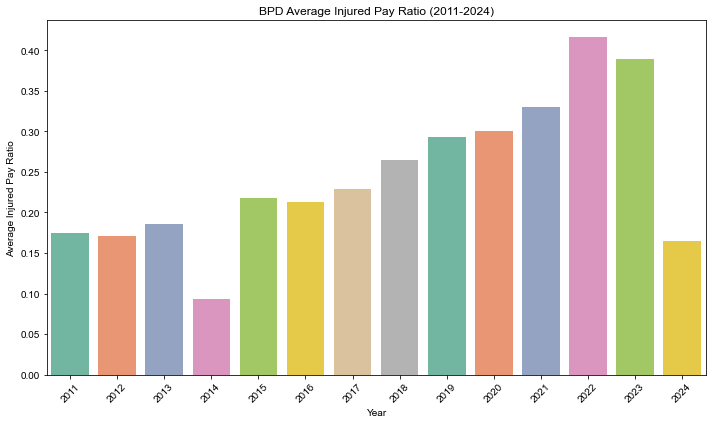

In [14]:
# Plot the average injured ratio per year
plt.figure(figsize=(10, 6))
sns.barplot(x='YEAR', y='INJURED_RATIO', data=injured_ratio_avg, palette='Set2')
plt.title('BPD Average Injured Pay Ratio (2011-2024)')
plt.xlabel('Year')
plt.ylabel('Average Injured Pay Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# What percentage of officers took injury pay in a given year? 

In [15]:
# Count the number of injured officers each year
injured_counts = bpd_data_dropna.groupby('YEAR')['INJURED'].count().reset_index(name='INJURED_COUNT')
counts = bpd_data.groupby('YEAR')['TOTAL_GROSS'].count().reset_index(name='COUNT')
injured_counts = pd.merge(injured_counts, counts, on='YEAR', how='outer')

#  Calculate the percentage of injured officers
injured_counts['INJURED_PERCENTAGE'] = (injured_counts['INJURED_COUNT'] / injured_counts['COUNT']) * 100

injured_counts


,YEAR,INJURED_COUNT,COUNT,INJURED_PERCENTAGE
0,2011,360,3013,11.948224
1,2012,328,3034,10.810811
2,2013,368,3085,11.928687
3,2014,830,3178,26.117055
4,2015,342,3034,11.272248
5,2016,449,3114,14.418754
6,2017,475,3149,15.084154
7,2018,461,3173,14.528837
8,2019,458,3271,14.001834
9,2020,647,3142,20.591980


/var/folders/64/dkndw9l10ls5pdzpx8fmcqpc0000gn/T/ipykernel_71237/544869917.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='YEAR', y='INJURED_PERCENTAGE', data=injured_counts, palette='Set2')


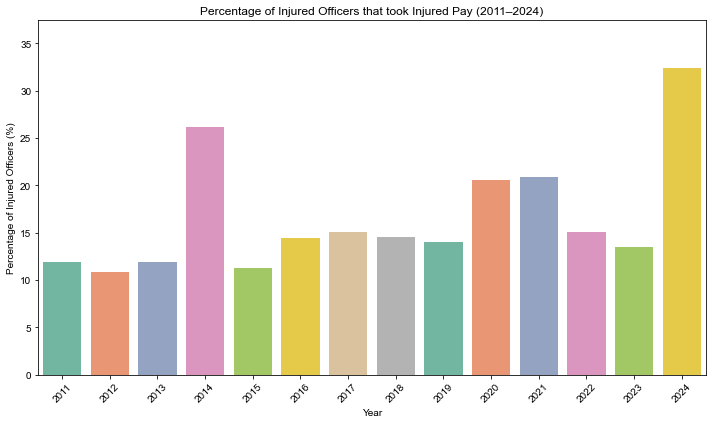

In [16]:

# Plot the percentage of injured officers by year
plt.figure(figsize=(10, 6))
sns.barplot(x='YEAR', y='INJURED_PERCENTAGE', data=injured_counts, palette='Set2')
plt.title('Percentage of Injured Officers that took Injured Pay (2011–2024)')
plt.xlabel('Year')
plt.ylabel('Percentage of Injured Officers (%)')
plt.xticks(rotation=45)
plt.ylim(0, injured_counts['INJURED_PERCENTAGE'].max() + 5)  # Add some space above the max value
plt.tight_layout()
plt.show()